<a href="https://colab.research.google.com/github/taji99/python_basic/blob/master/200729_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# オートエンコーダの実装
オートエンコーダ（自己符号器）を実装します。  
Encoderで中間層に画像を圧縮した後に、Decoderで元の画像を再構築しましょう。

## 訓練用データの用意
オートエンコーダに用いる訓練用のデータを用意します。  
MNIST（手書き文字）のデータを読み込み、表示します。

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


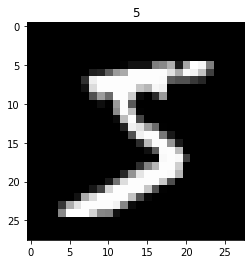

(60000, 784) (10000, 784)


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()  # MNISTの読み込み
print(x_train.shape, x_test.shape)  # 28x28の手書き文字画像が6万枚

# 各ピクセルの値を0-1の範囲に収める
x_train = x_train / 255
x_test = x_test / 255

# 手書き文字画像の表示
plt.imshow(x_train[0].reshape(28, 28), cmap="gray")
plt.title(t_train[0])
plt.show() 

# 一次元に変換する
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape, x_test.shape)

## オートエンコーダの各設定
オートエンコーダに必要な各設定を行います。

In [2]:
epochs = 20  
batch_size = 128
n_in_out = 784  # 入出力層のニューロン数
n_mid = 64  # 中間層のニューロン数

 ## モデルの構築
 Kerasによりオートエンコーダのモデルを構築します。  
 Encoder、Decoderの順に層を重ねます。

In [3]:
from keras.models import Model
from keras.layers import Input, Dense

# オートエンコーダのネットワーク構築
x = Input(shape=(n_in_out,))
h = Dense(n_mid, activation="relu")(x)  # Encoder
decoder = Dense(n_in_out, activation="sigmoid")  #Decoder 後ほど再利用
y = decoder(h)

# オートエンコーダのモデルを作成
model_autoencoder = Model(x, y)
model_autoencoder.compile(optimizer="adadelta", loss="binary_crossentropy")
model_autoencoder.summary()

# Encoderのみのモデル
model_encoder = Model(x, h)

# Decoderのみのモデル
input_decoder = Input(shape=(n_mid,))
model_decoder = Model(input_decoder, decoder(input_decoder))

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


## 学習
構築したオートエンコーダのモデルを使って、学習を行います。  
入力を再現するように学習するので、正解は入力そのものになります。

In [4]:
model_autoencoder.fit(x_train, x_train,
                      shuffle=True,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 69us/step - loss: 0.3006 - val_loss: 0.2412
Epoch 2/20
60000/60000 [==============================] - 4s 64us/step - loss: 0.2205 - val_loss: 0.2010
Epoch 3/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1911 - val_loss: 0.1802
Epoch 4/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.1743 - val_loss: 0.1663
Epoch 5/20
60000/60000 [==============================] - 4s 66us/step - loss: 0.1622 - val_loss: 0.1556
Epoch 6/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.1526 - val_loss: 0.1469
Epoch 7/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.1446 - val_loss: 0.1395
Epoch 8/20
60000/60000 [==============================] - 4s 63us/step - loss: 0.1379 - val_loss: 0.1334
Epoch 9/20
60000/60000 [==============================] - 4s 65us/step - loss: 0.1321 - val_loss: 0.1279
Epoch

## 生成結果
入力画像と生成画像を比較します。  
また、中間層の出力も画像に変換し可視化します。

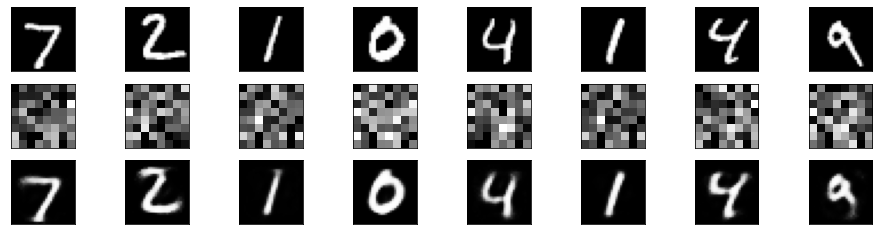

In [5]:
encoded = model_encoder.predict(x_test)
decoded = model_decoder.predict(encoded)

n = 8  # 表示する画像の数
plt.figure(figsize=(16, 4))
for i in range(n):
    # 入力画像
    ax = plt.subplot(3, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 中間層の出力
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(encoded[i].reshape(8,8), cmap="Greys_r") #画像サイズは、中間層のニューロン数に合わせて変更する
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 出力画像
    ax = plt.subplot(3, n, i+1+2*n)
    plt.imshow(decoded[i].reshape(28, 28), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

28x28の画像がEncoderにより8x8に圧縮された後、Decoderにより展開されてもとの画像が再構築されました。  
展開された画像は多少ぼやけていますが、オートエンコーダにより画像の特徴を少ない変数に圧縮できることが確認できました。